In [1]:
from importlib import reload

import torch
import torch.nn as nn
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context


import matplotlib.pyplot as plt
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint

CACHE_DIR = "/home/mila/s/soroush.omranpour/scratch/hf_cache/"

## Model

In [2]:
import src.models.vlm
reload(src.models.vlm)
from src.models.vlm import MultimodalLightningModel

# model = MultimodalLightningModel.load_from_checkpoint(
#     'weights/omnivlm+-finetune-cauldron/pt-lape-shuffle-4-all--epoch=01-val_loss=1.18.ckpt',
#     token_reduction_mode='shuffle',
#     token_reduction_factor=4,
#     image_positional_encoding='lape',
#     max_image_length=50,
#     freeze_lm=False, 
#     freeze_encoder=False, 
#     lr_proj=1e-3, 
#     lr_enc=1e-4,
#     lr_lm=1e-4
# )

model = MultimodalLightningModel(
    enc_name="stabilityai/sd-vae-ft-ema", 
    lm_name="HuggingFaceTB/SmolLM-135M",
    token_reduction_mode='shuffle',
    token_reduction_factor=4,
    image_positional_encoding='lape',
    max_image_length=50,
    lr_lm=1e-4,
    lr_enc=1e-4,
    lr_proj=2e-3,
    freeze_encoder=False,
    freeze_lm=False,
    cache_dir=CACHE_DIR
)
model.count_parameters()

218900967

## Dataset

In [3]:
from datasets import get_dataset_config_names

subsets = get_dataset_config_names("HuggingFaceM4/the_cauldron")
print(subsets)

['ai2d', 'aokvqa', 'chart2text', 'chartqa', 'clevr', 'clevr_math', 'cocoqa', 'datikz', 'diagram_image_to_text', 'docvqa', 'dvqa', 'figureqa', 'finqa', 'geomverse', 'hateful_memes', 'hitab', 'iam', 'iconqa', 'infographic_vqa', 'intergps', 'localized_narratives', 'mapqa', 'mimic_cgd', 'multihiertt', 'nlvr2', 'ocrvqa', 'okvqa', 'plotqa', 'raven', 'rendered_text', 'robut_sqa', 'robut_wikisql', 'robut_wtq', 'scienceqa', 'screen2words', 'spot_the_diff', 'st_vqa', 'tabmwp', 'tallyqa', 'tat_qa', 'textcaps', 'textvqa', 'tqa', 'vistext', 'visual7w', 'visualmrc', 'vqarad', 'vqav2', 'vsr', 'websight']


In [3]:
import src.data.datasets
reload(src.data.datasets)
from src.data.datasets import LlavaPretrainDataset, CauldronDataset, UniMMChatDataset
from src.data.utils import get_split_loaders, get_test_loader

# root = '/home/mila/s/soroush.omranpour/scratch/hf_datasets/llava-pretrain/'
# dataset = LlavaPretrainDataset(
#     meta_dir=root + 'blip_laion_cc_sbu_558k_meta.json', 
#     img_dir=root + 'images/', 
#     eos_token=model.tokenizer.eos_token, 
#     max_length=64,
#     image_size=224
# )

dataset = CauldronDataset(
    subsets=[
        'ai2d', 'aokvqa', 'chart2text', 'chartqa', 'clevr', 'clevr_math', 'cocoqa', 'datikz',\
        'diagram_image_to_text', 'docvqa', 'figureqa', 'finqa', 'geomverse', 'hateful_memes',\
        'hitab', 'iam', 'iconqa', 'infographic_vqa', 'intergps', 'mapqa', 'multihiertt', 'okvqa',\
        'raven', 'robut_sqa', 'robut_wikisql', 'robut_wtq', 'scienceqa', 'screen2words',\
        'st_vqa', 'tabmwp', 'tallyqa', 'tat_qa', 'textcaps', 'textvqa', 'tqa', 'vistext',\
        'visual7w', 'visualmrc', 'vqarad', 'vqav2', 'vsr',\
        
        'dvqa', 'localized_narratives', 'ocrvqa', 'plotqa', 'rendered_text', 'websight'
    ],
    cache_dir='/home/mila/s/soroush.omranpour/scratch/hf_cache',
    image_size=224,
    max_length=128, 
    eos_token=model.tokenizer.eos_token,
)

# dataset = UniMMChatDataset(
#     cache_dir=CACHE_DIR,
#     image_size=224,
#     max_length=128, 
#     eos_token=model.tokenizer.eos_token,
# )

  0%|          | 0/47 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/563 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/44 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
train_loader, val_loader = get_split_loaders(
    dataset, 
    tokenizer=model.tokenizer,
    val_size=0.1, 
    batch_size=64, 
    num_workers=6
)

train size: 1575955  val size: 175106


## Trainer

In [5]:
project = 'omnivlm+-finetune-cauldron'
name = 'lape-shuffle-4-fullmodel'
wandb_logger = WandbLogger(
    project=project,
    name=name,
    save_dir='/home/mila/s/soroush.omranpour/scratch/wandb'
)
checkpoint_callback = ModelCheckpoint(
    dirpath=f"weights/{project}/",
    filename=name + "-{epoch:02d}-{val_loss:.3f}",
    save_top_k=1,
    monitor="val_loss",
    mode='min'
)
trainer = L.Trainer(
    max_epochs=1,
    devices=1,
    accelerator="gpu", 
    logger=wandb_logger,
    accumulate_grad_batches=1,
    gradient_clip_val=1.,
    num_nodes=1,
    callbacks=[checkpoint_callback],
    enable_checkpointing=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
model.lm.train()
model.image_encoder.train()
None

In [ ]:
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: soorism to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/mila/s/soroush.omranpour/Projects/my_env/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /network/scratch/s/soroush.omranpour/OmniVLMPlus/weights/omnivlm+-finetune-cauldron exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | lm            | LlamaForCausalLM  | 134 M  | train
1 | image_encoder | AutoencoderKL     | 83.7 M | train
2 | image_pe      | LAPE              | 28.8 K | train
3 | projector     | ModalityProjector | 702 K  | train
4 | dropout       | Dropout           | 0      | train
  | other params  | n/a               | 1.2 K  | n/a  
------------------------------------------------------------
218 M     Trainable params
0         Non-trainable params
218 M     Total params
875.604   Total estimated model params size (MB)
648       Modules in train mode
0         Modules in eval mod

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

In [16]:
trainer.save_checkpoint('test.ckpt')

## Test

In [9]:
import src.data.datasets
reload(src.data.datasets)

import src.data.collators
reload(src.data.collators)

import src.data.utils
reload(src.data.utils)
from src.data.datasets import MMStarDataset, ScienceQADataset
from src.data.utils import get_test_loader, get_split_loaders

test_ds = ScienceQADataset(split='validation', cache_dir=CACHE_DIR, eos_token=model.tokenizer.eos_token, image_size=224, max_length=128)
tl = get_test_loader(test_ds, tokenizer=model.tokenizer, batch_size=64, num_workers=1)

test size: 4241


In [8]:
import src.models.vlm
reload(src.models.vlm)
from src.models.vlm import MultimodalLightningModel

# model = MultimodalLightningModel.load_from_checkpoint(
#     'test.ckpt',
#     token_reduction_mode='shuffle',
#     token_reduction_factor=4,
#     image_positional_encoding='lape',
#     max_image_length=50,
# )
model.lm.eval()
model.image_encoder.eval()
model.eval()
None

In [10]:
# trainer.test(model, tl)

In [20]:
from tqdm.auto import tqdm

model.eval()
device = 'cuda'
c = 0
n = 0
for batch in tqdm(tl):
    question = model.tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True)
    correct_answer = model.tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
    pred = model.run(
        batch['input_ids'], 
        batch['image'], 
        attention_mask=batch['attention_mask'], 
        device=device,
        max_new_tokens=1,
        temperature=1, top_k=30, top_p=0.9, greedy=True
    )
    break

  0%|          | 0/67 [00:00<?, ?it/s]

In [25]:
print(question[20])

Question: Select the bird below.gray tree frog, pelican Answer: 


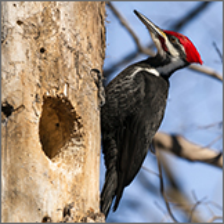

In [27]:
from torchvision.transforms import ToPILImage
ToPILImage()(batch['image'][20])

In [28]:
p = pred[20].strip().lower()
g = correct_answer[20].strip().lower()
print(p, ':', g)

1 : 1
